# Rice Grain Classifier using PyTorch

## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import os
import shutil

## Setting Up folders and Importing Data

In [2]:
# Folder names representing classes
folder_names = ("Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag")

# Create train, validation, and test directories
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)
        for class_name in folder_names:
            os.makedirs(os.path.join(folder, class_name))

In [3]:
# Split the data into train, validation, and test sets
for class_name in folder_names:
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 validation

    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

In [4]:
# Define transformations for the training, validation, and testing datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 to reduce computational load
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load the rice dataset
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = data.DataLoader(train_data, batch_size=8, shuffle=True)  # Reduced batch size for lower memory usage
val_loader = data.DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = data.DataLoader(test_data, batch_size=8, shuffle=False)

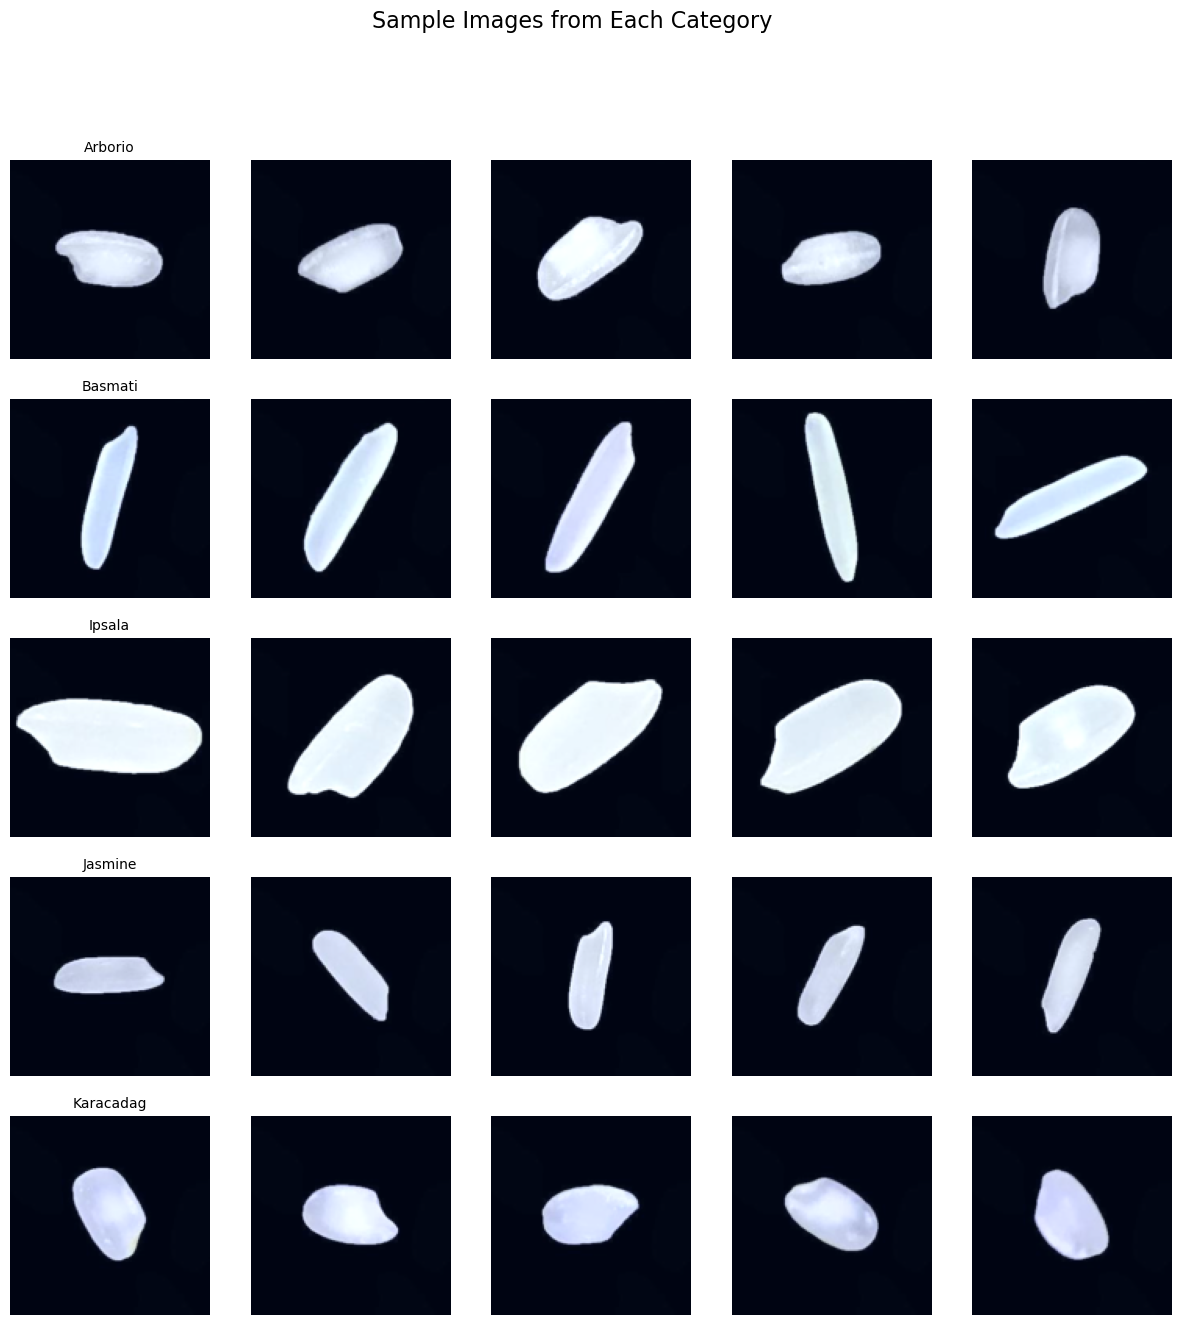

In [6]:
# Show a 5*5 grid with sample images, 5 images from each category
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Sample Images from Each Category', fontsize=16)

for i, class_name in enumerate(folder_names):
    class_images = [img[0] for img in train_data if img[1] == i][:5]
    for j, img_tensor in enumerate(class_images):
        img = img_tensor.permute(1, 2, 0).numpy() * 0.229 + 0.485  # Denormalize for visualization
        img = np.clip(img, 0, 1)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10)
plt.show()

## Defining the CNN Model

Input Layer: Takes in RGB images of size (3x128x128).
Feature Extraction Layers:

    - Conv2D Layer 1: 32 filters, kernel size 3x3, padding=1, followed by ReLU activation.
    - MaxPooling Layer 1: Kernel size 2x2, stride=2.
    - Conv2D Layer 2: 64 filters, kernel size 3x3, padding=1, followed by ReLU activation.
    - MaxPooling Layer 2: Kernel size 2x2, stride=2.
    - Conv2D Layer 3: 128 filters, kernel size 3x3, padding=1, followed by ReLU activation.
    - MaxPooling Layer 3: Kernel size 2x2, stride=2.

Flatten Layer: Converts the output of the feature extraction to a 1D vector of size 128 * 16 * 16.
Fully Connected Layers:

    - Fully Connected Layer 1: 512 units, followed by ReLU activation and Dropout (p=0.5).
    - Fully Connected Layer 2: Outputs 5 units (for 5 classes)

In [7]:
# Define the custom CNN model from scratch with fewer layers to reduce complexity
class CNN_1(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
# Instantiate the model
model = CNN_1(num_classes=5)

In [9]:
# Define the device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training the model
train_losses = []
val_losses = []
val_accuracies = []
epochs = 10  # Reduced number of epochs for quicker training
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch [1/10], Loss: 0.3454, Val Loss: 0.1072, Val Accuracy: 95.00%
Epoch [2/10], Loss: 0.1283, Val Loss: 0.0813, Val Accuracy: 97.30%
Epoch [3/10], Loss: 0.1165, Val Loss: 0.0544, Val Accuracy: 98.20%
Epoch [4/10], Loss: 0.0824, Val Loss: 0.1178, Val Accuracy: 95.70%
Epoch [5/10], Loss: 0.0739, Val Loss: 0.0449, Val Accuracy: 98.90%
Epoch [6/10], Loss: 0.0647, Val Loss: 0.0459, Val Accuracy: 98.60%
Epoch [7/10], Loss: 0.0664, Val Loss: 0.0592, Val Accuracy: 98.40%
Epoch [8/10], Loss: 0.0599, Val Loss: 0.0588, Val Accuracy: 98.60%
Epoch [9/10], Loss: 0.0570, Val Loss: 0.0447, Val Accuracy: 98.20%
Epoch [10/10], Loss: 0.0523, Val Loss: 0.0502, Val Accuracy: 98.60%


In [12]:
# Testing the model
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.70%


## Evaluating the Model

In [13]:
# Save the trained model
torch.save(model.state_dict(), 'rice_classifier_cnn.pth')

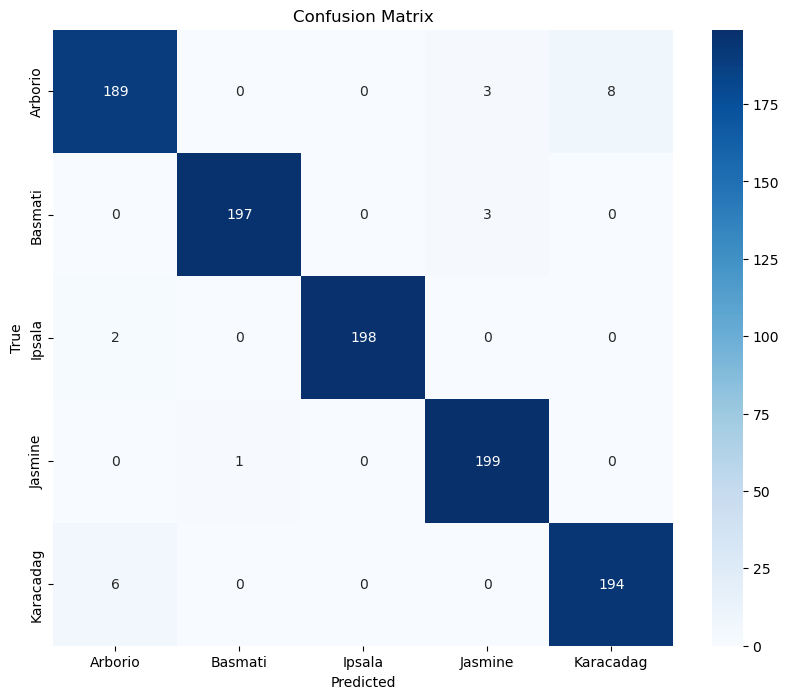

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=folder_names, yticklabels=folder_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

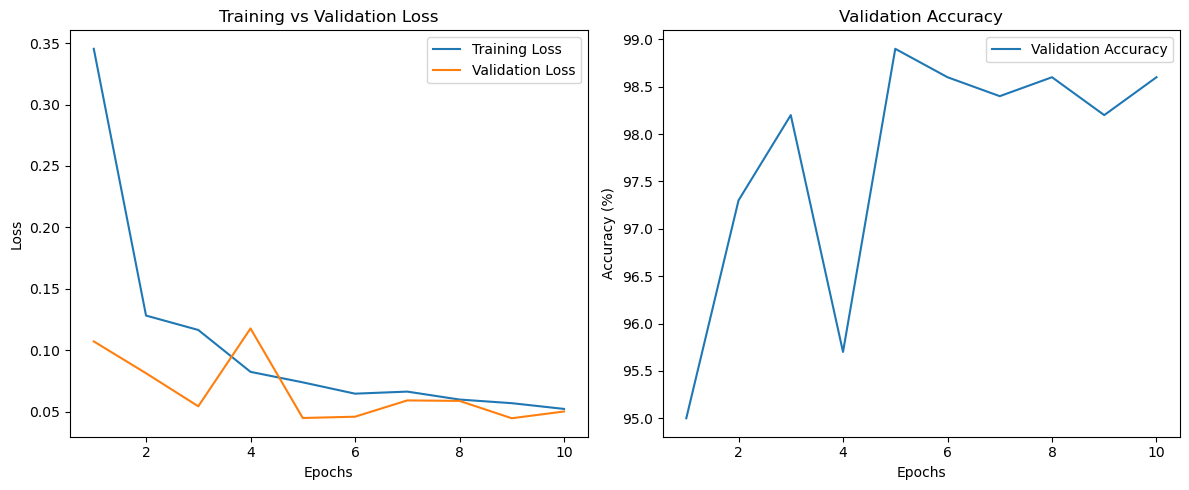

In [15]:
# Accuracy and Loss comparison between Training and Validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [16]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=folder_names))

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.96      0.94      0.95       200
     Basmati       0.99      0.98      0.99       200
      Ipsala       1.00      0.99      0.99       200
     Jasmine       0.97      0.99      0.98       200
   Karacadag       0.96      0.97      0.97       200

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



The classification report demonstrates excellent performance of the model, with an overall accuracy of 98%. All classes have high precision, recall, and F1-scores, indicating that the model effectively distinguishes between the five rice varieties. Notably, the Ipsala and Basmati classes achieved near-perfect metrics, while other classes also performed consistently well, reflecting a well-generalized model.